In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
palette = {
    "phone": "#2F4B7C",      # deep navy
    "chat": "#4C72B0",       # softer blue
    "video": "#2A9FD6",      # sky blue
    "other": "#4C4C4C"       # charcoal
}

sns.set_palette(list(palette.values()))

In [3]:
df = pd.read_csv(r"C:\Users\pc\Desktop\Pro_Jets\CC EDA&ML\Data\bank-call-center-interaction-logs.csv")
df.head()

,interaction_id,customer_id,agent_id,interaction_datetime,interaction_duration_seconds,call_direction,call_channel,call_status,customer_satisfaction_score,speech_sentiment_score,speech_transcript,topics_detected,issue_resolved,follow_up_required,follow_up_due_date,language,customer_feedback_text,agent_notes
0,INT00001,CUST00001,AGT0001,2024-01-01T09:10:13,415,inbound,phone,completed,4.7,0.82,"Hello, I need help resetting my password please.","password_reset,online_banking",True,False,NaN,en,"Thank you for your help, great service.",Customer called regarding password reset. Issu...
1,INT00002,CUST00002,AGT0002,2024-01-01T11:24:50,23,outbound,phone,dropped,NaN,NaN,NaN,NaN,False,False,NaN,en,NaN,Call dropped instantly. No customer response.
2,INT00003,CUST00003,AGT0003,2024-01-01T13:32:05,198,inbound,chat,completed,4.1,0.63,"Hi, I want to check my last three statements.","statement_request,balance_inquiry",True,False,NaN,es,"Gracias, todo bien.",Customer requested recent statements. Provided...
3,INT00004,CUST00001,AGT0004,2024-01-02T10:45:14,37,inbound,phone,abandoned,0.0,-0.95,NaN,NaN,False,False,NaN,en,NaN,Caller disconnected before an agent could answer.
4,INT00005,CUST00004,AGT0001,2024-01-02T15:08:55,720,inbound,phone,completed,4.5,0.91,I am having trouble with my debit card online ...,"card_issue,online_payment",True,False,NaN,en,Resolved my issue quickly.,Customer reported card decline online. Walked ...


### **EDA Phase 1 - Getting a Feel of the DataSet**

In [4]:
df_copy = df.copy()

df_copy.describe()

,interaction_duration_seconds,customer_satisfaction_score,speech_sentiment_score
count,200.000000,154.000000,144.000000
mean,276.165000,3.307143,0.423194
std,271.466828,1.532016,0.546828
min,18.000000,0.000000,-1.000000
25%,61.750000,3.050000,0.440000
50%,203.500000,3.900000,0.600000
75%,393.000000,4.300000,0.770000
max,1680.000000,4.900000,0.970000


In [5]:
df_copy.info()
df_copy.isna().mean().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   interaction_id                200 non-null    object 
 1   customer_id                   200 non-null    object 
 2   agent_id                      200 non-null    object 
 3   interaction_datetime          200 non-null    object 
 4   interaction_duration_seconds  200 non-null    int64  
 5   call_direction                200 non-null    object 
 6   call_channel                  200 non-null    object 
 7   call_status                   200 non-null    object 
 8   customer_satisfaction_score   154 non-null    float64
 9   speech_sentiment_score        144 non-null    float64
 10  speech_transcript             137 non-null    object 
 11  topics_detected               135 non-null    object 
 12  issue_resolved                200 non-null    bool   
 13  follo

follow_up_due_date              0.915
customer_feedback_text          0.375
topics_detected                 0.325
speech_transcript               0.315
speech_sentiment_score          0.280
customer_satisfaction_score     0.230
customer_id                     0.000
interaction_id                  0.000
agent_id                        0.000
interaction_datetime            0.000
call_channel                    0.000
call_status                     0.000
interaction_duration_seconds    0.000
call_direction                  0.000
follow_up_required              0.000
issue_resolved                  0.000
language                        0.000
agent_notes                     0.000
dtype: float64

#### **How many inbound channels are there?**

In [6]:
df_copy["call_channel"].unique()

array(['phone', 'chat', 'video'], dtype=object)

In [7]:
# call volumne by channel
df_copy["call_channel"].value_counts()

call_channel
phone    123
chat      53
video     24
Name: count, dtype: int64

**Some data preperation**

In [8]:
# Convert datetime
df_copy["interaction_datetime"] = pd.to_datetime(df_copy["interaction_datetime"], errors="coerce")

# Create time features
df_copy["call_hour"] = df_copy["interaction_datetime"].dt.hour
df_copy["call_dayofweek"] = df_copy["interaction_datetime"].dt.day_name()

# Convert topics to lists
df_copy["topics_detected"] = df_copy["topics_detected"].fillna("").apply(
    lambda x: [i.strip() for i in x.split(",") if i]
)

# Ensure numeric columns are numeric
df_copy["interaction_duration_seconds"] = pd.to_numeric(df_copy["interaction_duration_seconds"], errors="coerce")
df_copy["customer_satisfaction_score"] = pd.to_numeric(df_copy["customer_satisfaction_score"], errors="coerce")
df_copy["speech_sentiment_score"] = pd.to_numeric(df_copy["speech_sentiment_score"], errors="coerce")

In [9]:
df_copy["issue_resolved"].mean()


# So we can already say:

# Many calls are NOT resolved,
# but only a small % escalate to structured follow-ups.

np.float64(0.59)

In [10]:
df_copy["follow_up_required"].mean()

np.float64(0.085)

**Next cell shows the information summary about the data**

In [11]:
summary = {
    "Total Calls": len(df_copy),
    "Resolved %": round(df_copy["issue_resolved"].mean()*100, 1),
    "Follow-up %": round(df_copy["follow_up_required"].mean()*100, 1),
    "Avg Duration (mins)": round(df_copy["interaction_duration_seconds"].mean()/60, 2),
    "Avg CSAT": round(df_copy["customer_satisfaction_score"].mean(), 2),
    "Avg Sentiment": round(df_copy["speech_sentiment_score"].mean(), 2),
}

summary

{'Total Calls': 200,
 'Resolved %': np.float64(59.0),
 'Follow-up %': np.float64(8.5),
 'Avg Duration (mins)': np.float64(4.6),
 'Avg CSAT': np.float64(3.31),
 'Avg Sentiment': np.float64(0.42)}

### **EDA Phase 2 - Exploring Distributions**

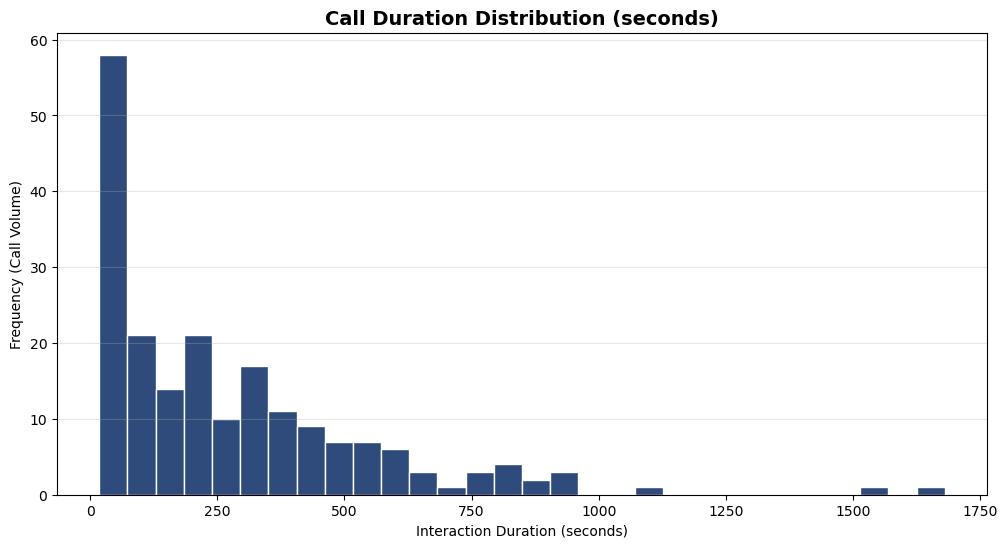

In [50]:
# Create the plot
plt.figure(figsize=(12, 6))

# 'bins' sets the granularity, 'color' sets the fill, and 'edgecolor' adds definition
plt.hist(
    df_copy["interaction_duration_seconds"], 
    bins=30, 
    color= "#2F4B7C", 
    edgecolor="white"
)

# Add labels and title
plt.title("Call Duration Distribution (seconds)", fontsize=14, fontweight='bold')
plt.xlabel("Interaction Duration (seconds)")
plt.ylabel("Frequency (Call Volume)")

# Add a grid for better readability of volumes
plt.grid(axis='y', alpha=0.3)

plt.show()

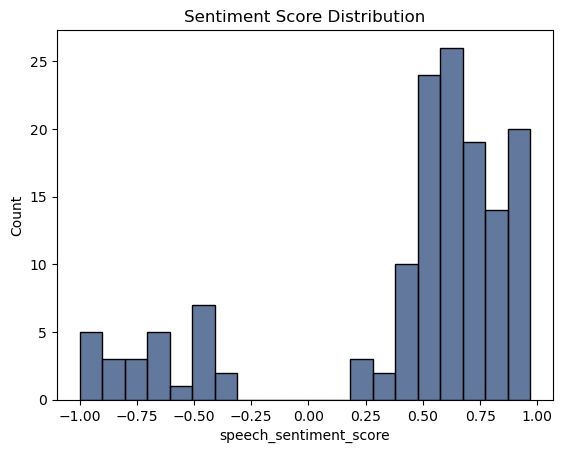

In [13]:
# The plot to show the measure of speach sentiments
sns.histplot(df_copy["speech_sentiment_score"].dropna(), bins=20)
plt.title("Sentiment Score Distribution")
plt.show()

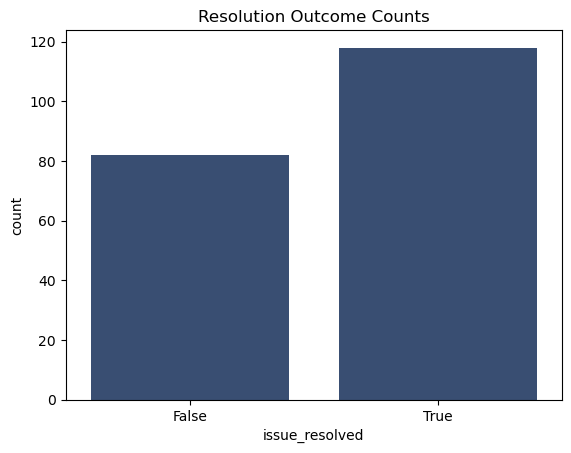

In [14]:
# The outcome measurement will be shown by this plot
sns.countplot(x="issue_resolved", data=df_copy)
plt.title("Resolution Outcome Counts")
plt.show()

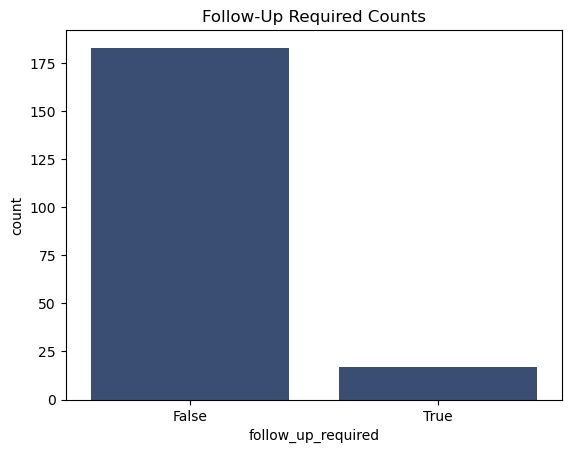

In [15]:
# How many calls requried follow up?
sns.countplot(x="follow_up_required", data=df_copy)
plt.title("Follow-Up Required Counts")
plt.show()

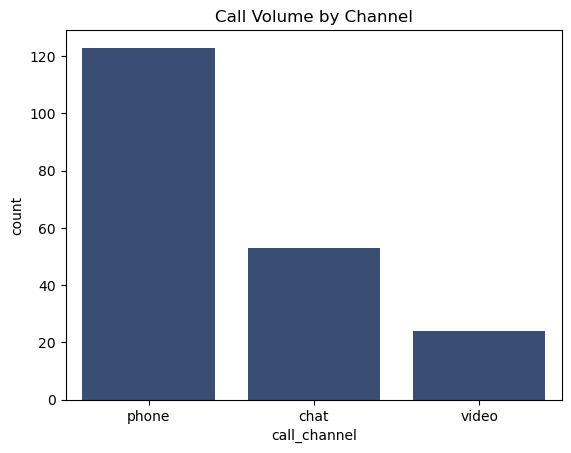

In [16]:
# grahic representation of the call volumne by channel
sns.countplot(x="call_channel", data=df_copy)
plt.title("Call Volume by Channel")
plt.show()

In [17]:
df_copy.drop(columns=["topics_detected"]).duplicated().sum()

np.int64(0)

### **EDA Phase 3 - Answering Key Questions** 

In [18]:
# Exploding the topics detected (we made this a list ealier)
df_topics = df_copy.explode("topics_detected")

In [19]:
# 
topic_duration = (
    df_topics.groupby("topics_detected")["interaction_duration_seconds"]
    .mean()
    .sort_values(ascending=False)
)

topic_duration

topics_detected
complaint           941.2
event_invitation    927.0
account_issues      883.0
account_fees        829.0
features            811.0
                    ...  
limit_increase      121.0
checking_account    117.0
address_change      114.0
payment_inquiry      89.0
email_update         73.0
Name: interaction_duration_seconds, Length: 92, dtype: float64

**What where the most discussed topics?**

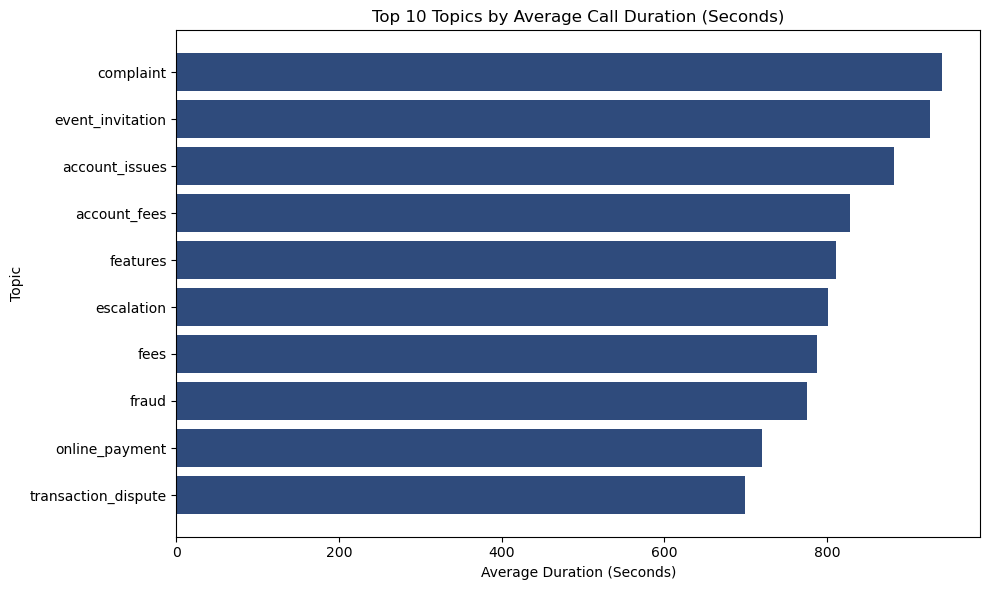

In [42]:
# Prepare data
top_topics = topic_duration.sort_values(ascending=False).head(10)

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(top_topics.index, top_topics.values, color="#2F4B7C")

# Formatting
plt.title("Top 10 Topics by Average Call Duration (Seconds)")
plt.xlabel("Average Duration (Seconds)")
plt.ylabel("Topic")

# Invert y-axis so the highest value is at the top (standard for "top 10" lists)
plt.gca().invert_yaxis() 

plt.tight_layout()
plt.show()

**How many calls were completed and how many were not?**

In [21]:
unique_names = df_copy['call_status'].unique()
print("Unique Names:", unique_names)

Unique Names: ['completed' 'dropped' 'abandoned' 'transferred']


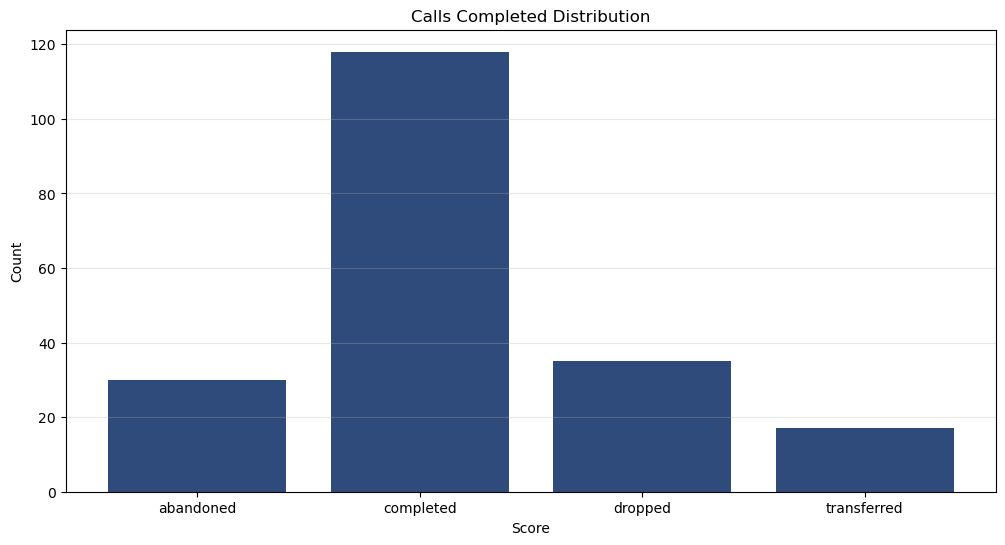

In [52]:
# Distributions of the calls outcome 
csat_counts = df_copy['call_status'].round().value_counts().sort_index()

plt.figure(figsize=(12,6))
plt.bar(csat_counts.index, csat_counts.values)
plt.title("Calls Completed Distribution")
plt.xlabel("Score")
plt.ylabel("Count")


# Grid for better readability of volumes
plt.grid(axis='y', alpha=0.3)

plt.show()

**What where the ratings by customers after calls?**

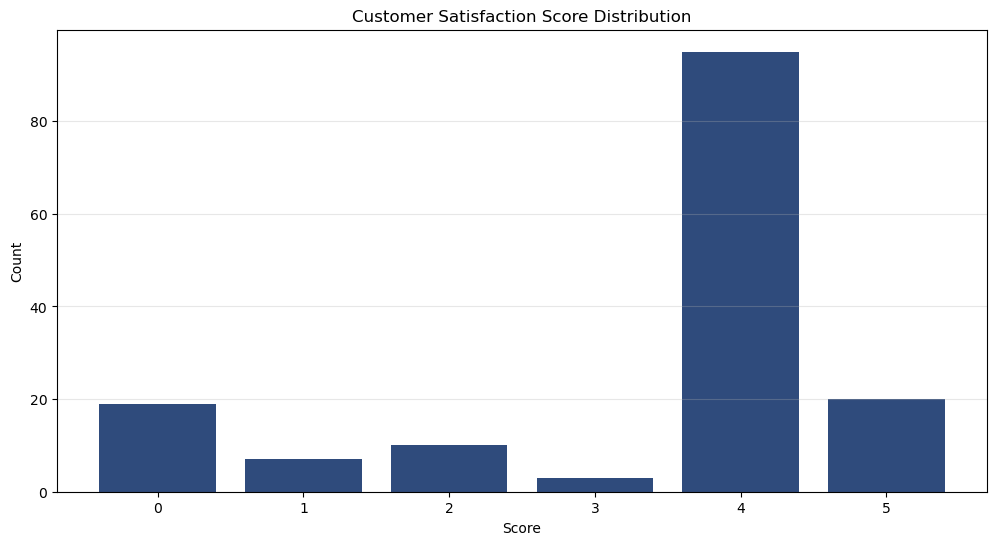

In [53]:
# Distributions of the rating scores recieved from customers 
csat_counts = df_copy['customer_satisfaction_score'].round().value_counts().sort_index()

plt.figure(figsize=(12,6))
plt.bar(csat_counts.index, csat_counts.values)
plt.grid(axis='y', alpha=0.3)
plt.title("Customer Satisfaction Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

### **EDA Phase 4 — Diving Deeper** 

**Objective:** Identify the agents who successfully resolve the highest number of customer interactions. This helps highlight high-capacity contributors who close a large share of customer issues.

**Approach:** We used the issue_resolved field (boolean) to determine whether a call was successfully resolved. 
Then we:

Grouped calls by agent
Counted how many resolved calls each agent handled
Sorted the results in descending order
Plotted the Top 10 agents by number of resolved calls

This gives us a direct view of who is closing the most cases overall.

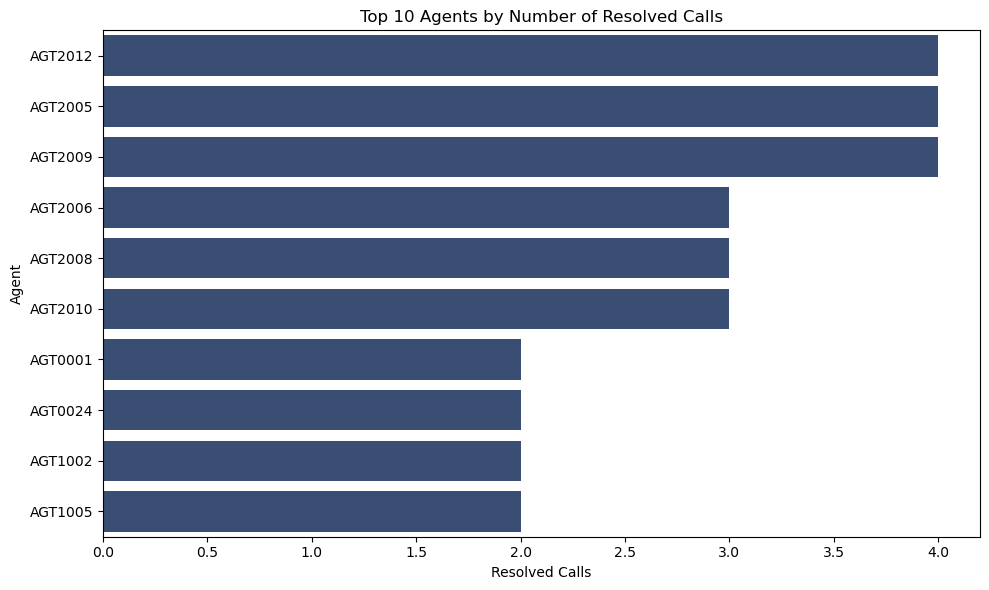

In [24]:
resolved_per_agent = (
    df_copy.groupby('agent_id')['issue_resolved']
    .sum()
    .sort_values(ascending=False)
)

top10_resolved = resolved_per_agent.head(10).reset_index()
top10_resolved.columns = ["agent_id", "resolved_calls"]

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_resolved,
    x="resolved_calls",
    y="agent_id"
)
plt.title("Top 10 Agents by Number of Resolved Calls")
plt.xlabel("Resolved Calls")
plt.ylabel("Agent")
plt.tight_layout()
plt.show()

### **What times of day see lowest CSAT scores?**

In [25]:
# Making the plot of calls volumes per hour
df_copy['interaction_datetime'] = pd.to_datetime(df_copy['interaction_datetime'])
df_copy['hour'] = df_copy['interaction_datetime'].dt.hour

In [26]:
csat_by_hour = (
    df_copy
    .groupby('hour')['customer_satisfaction_score']
    .mean()
    .sort_index()
)
# csat_by_hour

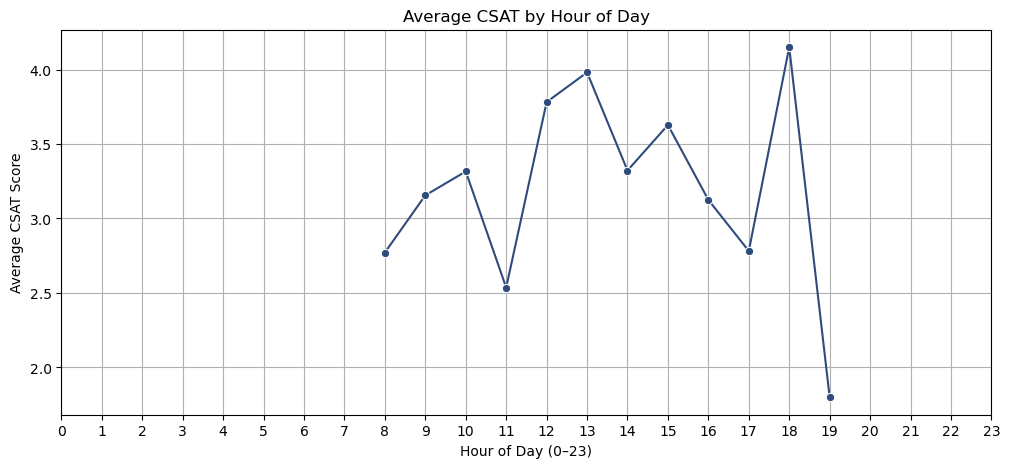

In [27]:
plt.figure(figsize=(12,5))
sns.lineplot(x=csat_by_hour.index, y=csat_by_hour.values, marker="o")
plt.title("Average CSAT by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average CSAT Score")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

### **How does the call volume amount affect CSAT score?**

**We'll be overlaying the CSAt score by hour to the Call volumne by hour to answer this question.**

In [28]:
calls_by_hour = df_copy.groupby('hour').size()

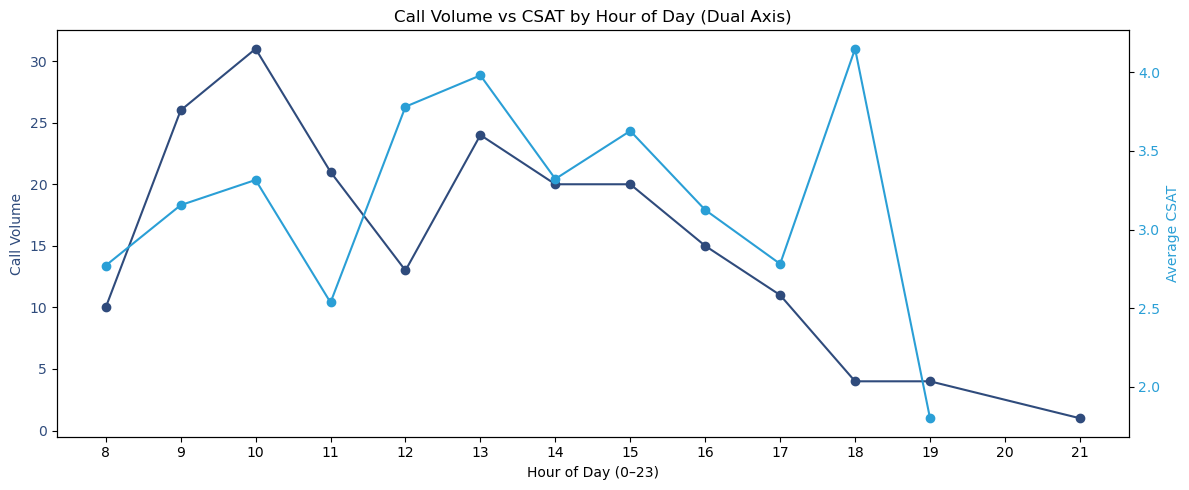

In [34]:
fig, ax1 = plt.subplots(figsize=(12,5))

# Left Y-axis: Call Volume (Red)
ax1.plot(
    calls_by_hour.index,
    calls_by_hour.values,
    marker='o',
    color="#2F4B7C",
    label='Call Volume'
)
ax1.set_xlabel("Hour of Day (0–23)")
ax1.set_ylabel("Call Volume", color="#2F4B7C")
ax1.tick_params(axis='y', labelcolor="#2F4B7C")
ax1.set_xticks(range(0,24))

# Right Y-axis: CSAT (Blue) 
ax2 = ax1.twinx()
ax2.plot(
    csat_by_hour.index,
    csat_by_hour.values,
    marker='o',
    color="#2A9FD6",
    label='Average CSAT'
)
ax2.set_ylabel("Average CSAT", color='#2A9FD6')
ax2.tick_params(axis='y', labelcolor='#2A9FD6')

plt.title("Call Volume vs CSAT by Hour of Day (Dual Axis)")
fig.tight_layout()
plt.show()


##### **Note:** between hour 17 and 18 as the calls volumnes drop drastically to bettween 10 to bellow 5, the we can see the CSAT scores reached there peak
##### There for this tells up that the low call volumne corelates with csat scores

#### **What is the rate of follow ups needed per channel?**

In [30]:
followup_rate = (
    df_copy.groupby('call_channel')['follow_up_required']
    .mean()
    .sort_values(ascending=False)
)

followup_count = (
    df_copy.groupby('call_channel')['follow_up_required']
    .sum()
    .sort_values(ascending=False)
)

followup_rate, followup_count



(call_channel
 phone    0.138211
 chat     0.000000
 video    0.000000
 Name: follow_up_required, dtype: float64,
 call_channel
 phone    17
 chat      0
 video     0
 Name: follow_up_required, dtype: int64)

**Final Summary:**
Phone calls account for 100% of follow-ups, with a follow-up rate of ~14%, meaning about 1 in 7 phone customers must reach out again. Chat and video produce zero follow-ups, suggesting that voice support is either handling more complex cases or has weaker resolution consistency compared to structured digital channels.

In [31]:
# See you in the next notebook
df_copy.to_csv('df_copy.csv', index=False)